In [13]:
import numpy as np
import cv2
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import math
import networkx as nx
!pip install powerlaw
import powerlaw
import pandas as pd
import xml.etree.ElementTree as ET
import openpyxl
import zlib
from collections import defaultdict


In [14]:
def find_clusters(image, min_cluster_size=2):
    # convert the image to binary if not already
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    rows, cols = binary_image.shape

    #Create a boolean array to keep track of visited pixels
    visited = np.zeros((rows, cols), dtype=bool)

    clusters = []

    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),         (0, 1),
                  (1, -1), (1, 0), (1, 1)]

    def dfs(x, y, cluster):
        stack = [(x, y)]
        while stack:
            cx, cy = stack.pop()
            if visited[cx, cy]:
                continue
            visited[cx, cy] = True
            cluster.append((cx, cy))

            # Explore all 8-connected neighbors
            for dx, dy in directions:
                nx, ny = cx + dx, cy + dy
                if 0 <= nx < rows and 0 <= ny < cols and not visited[nx, ny] and binary_image[nx, ny] == 255:
                    stack.append((nx, ny))

    # Traverse through all pixels
    for i in range(rows):
        for j in range(cols):
            if binary_image[i, j] == 255 and not visited[i, j]:
                # Start a new cluster
                cluster = []
                dfs(i, j, cluster)

                # Add the cluster if it meets the minimum size requirement
                if len(cluster) >= min_cluster_size:
                    clusters.append(cluster)

    return clusters  # Return the coordinates of all white pixels in clusters



def visualize_clusters(image, clusters):
    cluster_image = np.zeros((*image.shape, 3), dtype=np.uint8)

    def generate_bright_color():
        color = np.random.randint(0, 256, 3).tolist()
        while np.mean(color) > 200:
            color = np.random.randint(0, 256, 3).tolist()
        return tuple(color)

    for idx, cluster in enumerate(clusters):
        color = generate_bright_color()
        for (x, y) in cluster:
            cluster_image[x, y] = color

    return cluster_image

def create_adjacency_matrix(cluster):
    size = len(cluster)
    adjacency_matrix = np.zeros((size, size), dtype=int)

    #Convert list of pixel coordinates to a dictionary for quick lookup
    pixel_to_index = {pixel: idx for idx, pixel in enumerate(cluster)}

    #Directions for 8-connectivity
    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),         (0, 1),
                  (1, -1), (1, 0), (1, 1)]

    #fill the adjacency matrix
    for idx, (x, y) in enumerate(cluster):
        for dx, dy in directions:
            neighbor = (x + dx, y + dy)
            if neighbor in pixel_to_index:
                adjacency_matrix[idx, pixel_to_index[neighbor]] = 1

    return adjacency_matrix

def process_frame(frame, min_cluster_size=5):
    # Find the clusters for a single frame
    clusters = find_clusters(frame, min_cluster_size)

    # Generate adjacency matrices for each cluster
    adjacency_matrices = [create_adjacency_matrix(cluster) for cluster in clusters]

    # Visualize the clusters
    cluster_image = visualize_clusters(frame, clusters)

    return clusters, adjacency_matrices, cluster_image  # Return clusters, adjacency matrices, and visualization

def display_clusters(frame, clusters, cluster_image):
    # Create a new frame with a white background
    white_bg_frame = np.ones_like(frame) * 255  # White background
    white_bg_frame[frame == 255] = 0  # Invert only white pixels to black, keep others white

    # Create cluster_image_white and set non-zero pixels to white
    cluster_image_white = np.zeros_like(cluster_image)
    cluster_image_white[cluster_image == 0] = 255  # Invert only non-zero pixels to white, keep others black

    # Convert the grayscale image to RGB for better display with matplotlib
    white_bg_frame_rgb = cv2.cvtColor(white_bg_frame, cv2.COLOR_GRAY2RGB)
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    # Plot the original image and the cluster visualization
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(frame)
    ax[0].set_title("Original Frame")
    ax[1].imshow(cluster_image)
    ax[1].set_title("Cluster Visualization")

    plt.show()

def find_cluster_centers(clusters):
  """
  Finds the center of each cluster.

  Args:
    clusters: A list of clusters, where each cluster is a list of (i, j) coordinates.

  Returns:
    A list of (x, y) coordinates representing the center of each cluster.
  """
  centers = []
  for cluster in clusters:
    # Find the min and max i and j values for the cluster
    min_i = min([i for i, _ in cluster])
    max_i = max([i for i, _ in cluster])
    min_j = min([j for _, j in cluster])
    max_j = max([j for _, j in cluster])

    # Calculate the center coordinates
    center_x = (min_i + max_i) / 2
    center_y = (min_j + max_j) / 2

    centers.append((center_x, center_y))

  return centers

In [15]:
# Read the TIFF file
import tifffile as tiff
#Replace with own path
image_data = tiff.imread('/content/C2-6Ra_1.2-2.tif')
path = '/content/C2-6Ra_1.2-2.xlsx'


In [16]:
# Process each frame in the TIFF file
all_adjacency_matrices = {}  # Dictionary to store adjacency matrices
for frame_index, frame in enumerate(image_data):
    clusters, adjacency_matrices, _ = process_frame(frame)
    all_adjacency_matrices[frame_index] = {}
    for cluster_index, adjacency_matrix in enumerate(adjacency_matrices):
        all_adjacency_matrices[frame_index][cluster_index] = adjacency_matrix


In [17]:
def display_largest_cluster(frame, clusters, cluster_image):
    if not clusters:
        print("No clusters found.")
        return

    largest_cluster = max(clusters, key=len)
    largest_cluster_image = np.zeros((*frame.shape, 3), dtype=np.uint8)

    color = (255, 0, 0)

    # Ensure (x, y) coordinates are within bounds
    for (x, y) in largest_cluster:
        if 0 <= x < largest_cluster_image.shape[0] and 0 <= y < largest_cluster_image.shape[1]:
            largest_cluster_image[x, y] = color

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(frame_rgb)
    ax[0].set_title("Original Frame")
    ax[1].imshow(largest_cluster_image)
    ax[1].set_title("Largest Cluster Visualization")

    plt.show()

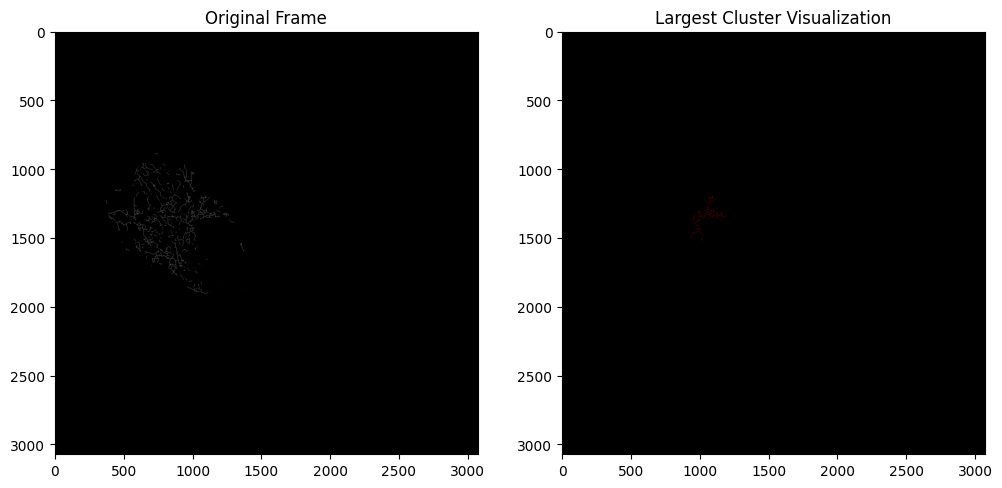

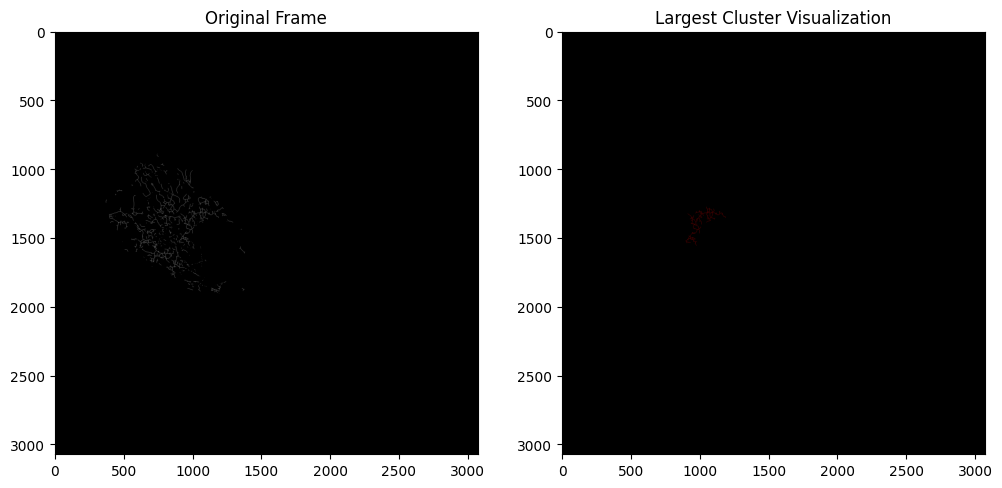

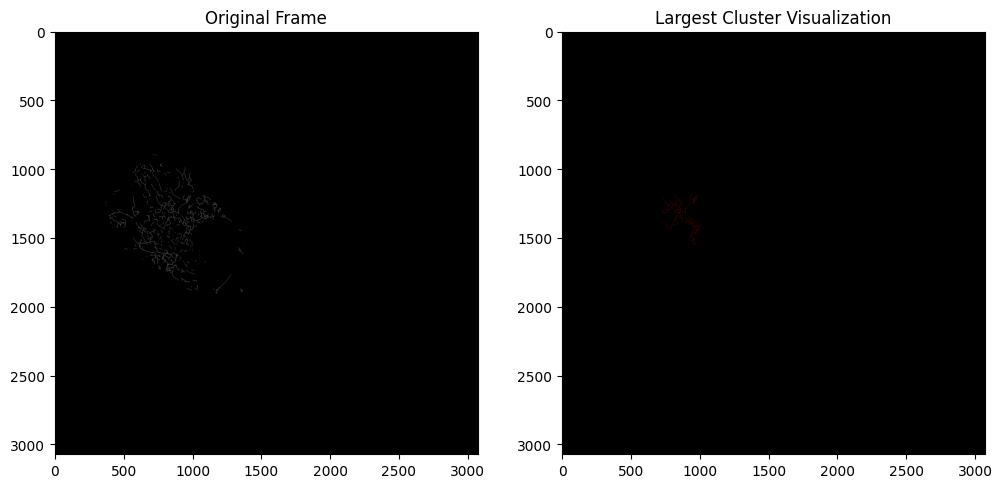

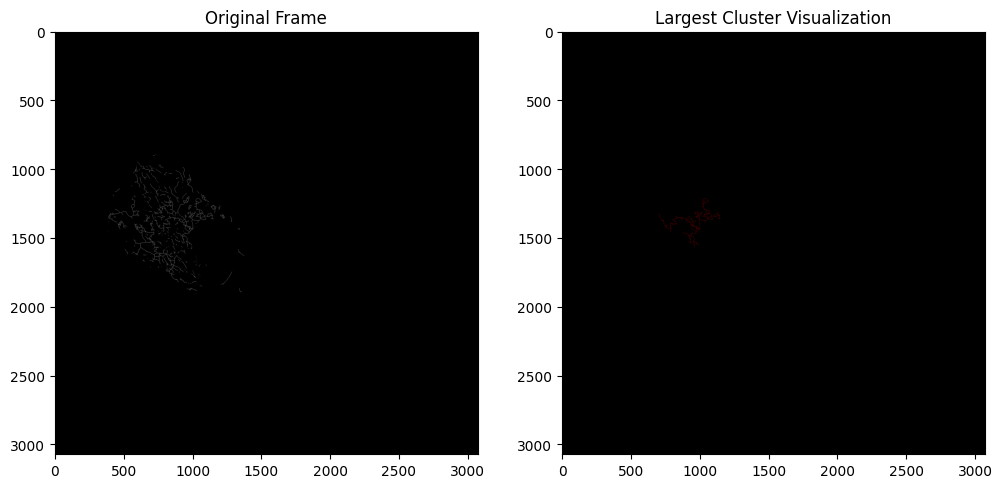

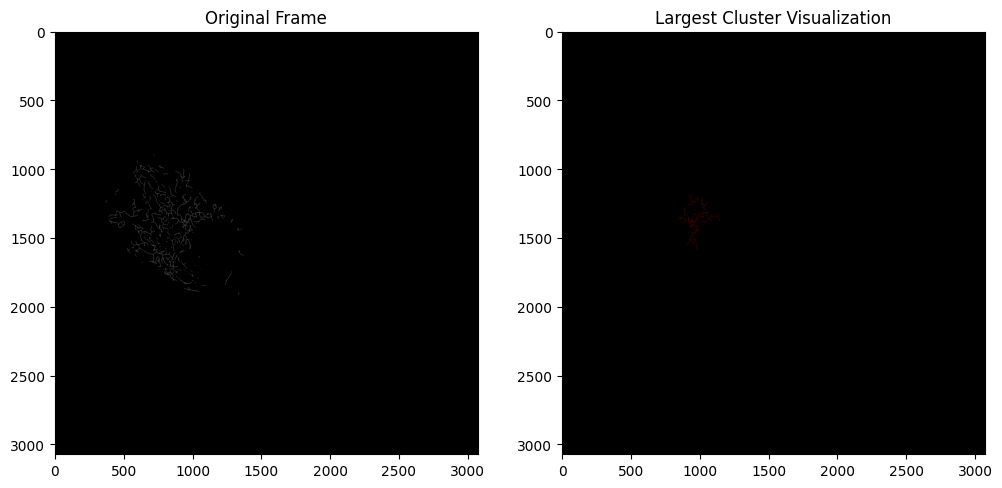

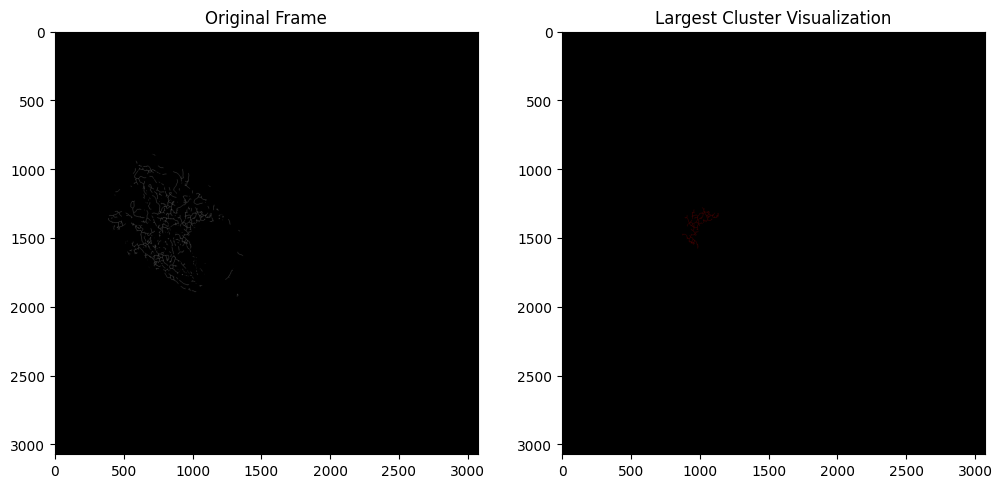

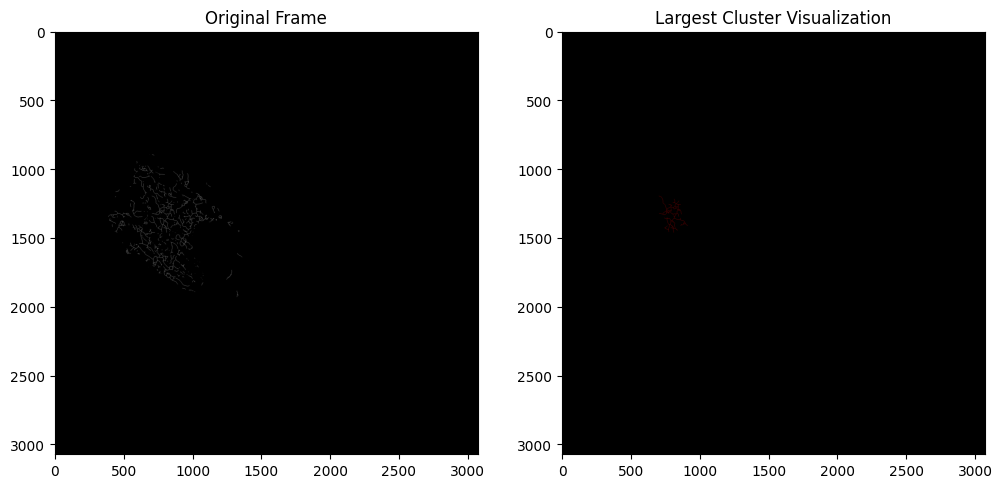

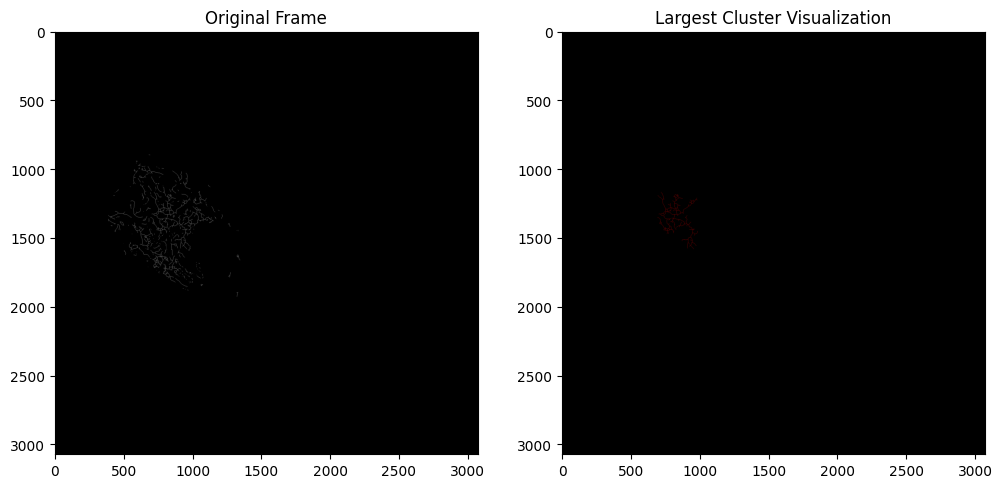

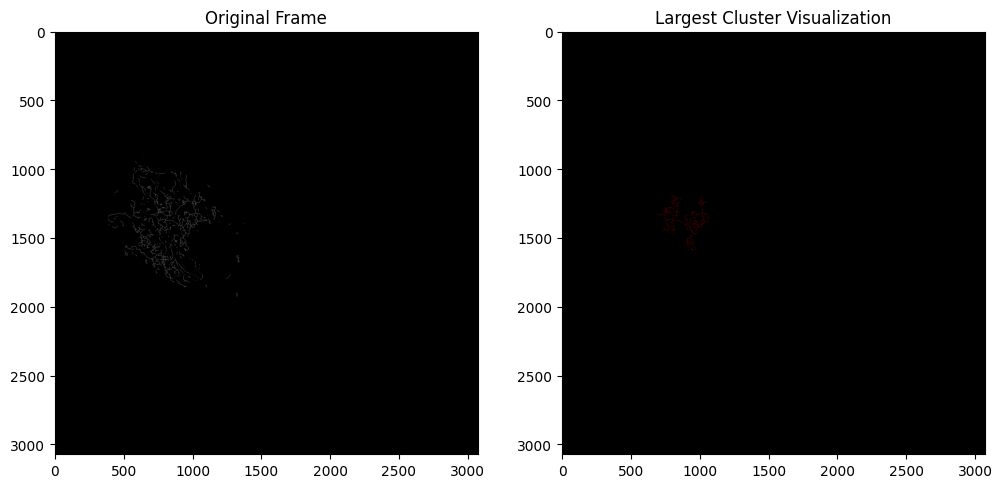

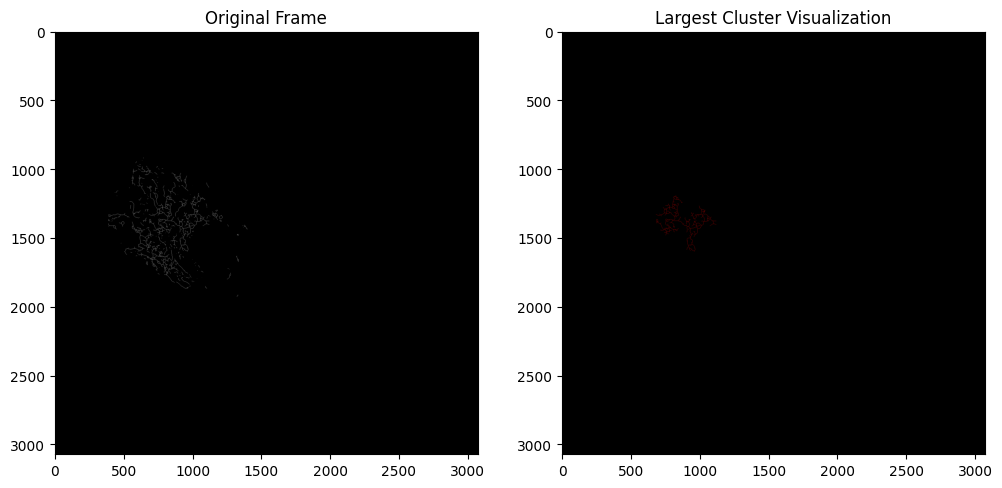

In [18]:
# Process each frame in the TIFF file
for frame_index, frame in enumerate(image_data):
    clusters, _, cluster_image = process_frame(frame)
    display_largest_cluster(frame, clusters, cluster_image)

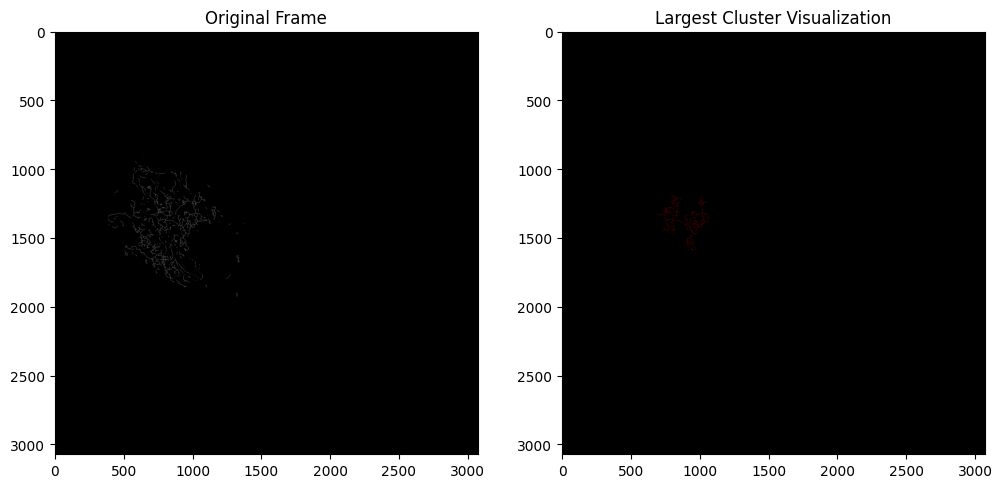

In [19]:
frame_index = 8
frame = image_data[frame_index]
clusters, adjacency_matrices, cluster_image = process_frame(frame)
display_largest_cluster(frame, clusters, cluster_image)

In [20]:
# Example: Access adjacency matrix for frame 3, cluster 7
frame_index = 3
cluster_index = 7

if frame_index in all_adjacency_matrices and cluster_index in all_adjacency_matrices[frame_index]:
  print(f"Frame: {frame_index}, Cluster: {cluster_index}, Adjacency Matrix:")
  print(all_adjacency_matrices[frame_index][cluster_index])
else:
  print(f"No adjacency matrix found for frame {frame_index}, cluster {cluster_index}")

Frame: 3, Cluster: 7, Adjacency Matrix:
[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]]


In [21]:

frame_index = 0  # Frame 1
largest_matrix_size = 0
largest_matrix_cluster = None
largest_matrix = None

if frame_index in all_adjacency_matrices:
  for cluster_index, adjacency_matrix in all_adjacency_matrices[frame_index].items():
    if adjacency_matrix.shape[0] > largest_matrix_size:
      largest_matrix_size = adjacency_matrix.shape[0]
      largest_matrix_cluster = cluster_index
      largest_matrix = adjacency_matrix

if largest_matrix is not None:
  print(f"In frame {frame_index}, the largest complex adjacency matrix belongs to cluster {largest_matrix_cluster}.")
  print("Largest Adjacency Matrix:")
  print(largest_matrix)
else:
  print(f"No adjacency matrices found for frame {frame_index}.")

In frame 0, the largest complex adjacency matrix belongs to cluster 35.
Largest Adjacency Matrix:
[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]


In [22]:
def simplify_adjacency_matrix(adj_matrix):
    G = nx.from_numpy_array(np.array(adj_matrix))

    # find all nodes with degree 2
    degree_dict = dict(G.degree())
    nodes_degree_2 = [node for node, degree in degree_dict.items() if degree == 2]

    # track visited nodes to avoid re-processing
    visited = set()

    for node in nodes_degree_2:
        if node not in visited:
            neighbors = list(G.neighbors(node))

            # If this node has exactly 2 neighbors, it's part of a chain
            if len(neighbors) == 2:
                chain = [node]
                visited.add(node)

                # Trace the entire chain of degree-2 nodes
                while True:
                    next_node = None
                    for neighbor in neighbors:
                        if G.degree[neighbor] == 2 and neighbor not in visited:
                            next_node = neighbor
                            break
                    if next_node is None:
                        break

                    chain.append(next_node)
                    visited.add(next_node)
                    neighbors = list(G.neighbors(next_node))

                # Collapse the chain into a single node
                if len(chain) > 1:
                    start_node = chain[0]
                    end_node = chain[-1]

                    #reconnect start_node and end_node's neighbors
                    start_neighbors = list(G.neighbors(start_node))
                    end_neighbors = list(G.neighbors(end_node))

                    for neighbor in start_neighbors:
                        if neighbor != chain[1]:
                            G.add_edge(start_node, neighbor)

                    for neighbor in end_neighbors:
                        if neighbor != chain[-2]:
                            G.add_edge(start_node, neighbor)

                    #remove internal nodes of the chain
                    for node_in_chain in chain[1:]:
                        G.remove_node(node_in_chain)

    #get the simplified adjacency matrix
    simplified_adj_matrix = nx.to_numpy_array(G)
    return simplified_adj_matrix


In [23]:
frame_index = 1
cluster_index = largest_matrix_cluster

if frame_index in all_adjacency_matrices and cluster_index in all_adjacency_matrices[frame_index]:
  complex_adj_matrix = all_adjacency_matrices[frame_index][cluster_index]
  simplified_adj_matrix = simplify_adjacency_matrix(complex_adj_matrix)

  print(f"Frame: {frame_index}, Cluster: {cluster_index}")
  print("Complex Adjacency Matrix:")
  print(complex_adj_matrix)

  print("\nSimplified Adjacency Matrix:")
  print(simplified_adj_matrix)

else:
  print(f"No adjacency matrix found for frame {frame_index}, cluster {cluster_index}")


Frame: 1, Cluster: 35
Complex Adjacency Matrix:
[[0 1 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 0 1 0 1 0 0 0]
 [0 0 0 1 0 1 0 0]
 [0 0 0 0 1 0 1 0]
 [0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 1 0]]

Simplified Adjacency Matrix:
[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]


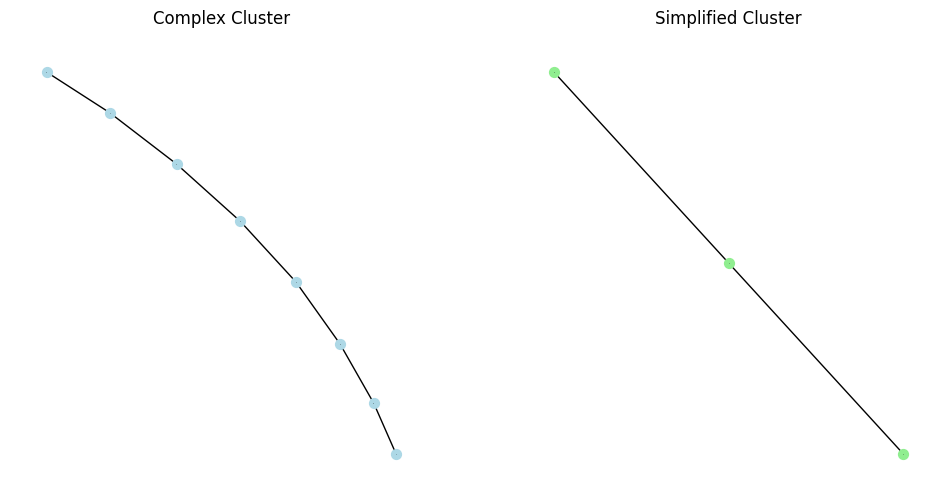

In [24]:
complex_adj_matrix = all_adjacency_matrices[frame_index][cluster_index]
simplified_adj_matrix = simplify_adjacency_matrix(complex_adj_matrix)

#create graphs from the adjacency matrices
G_complex = nx.from_numpy_array(np.array(complex_adj_matrix))
G_simplified = nx.from_numpy_array(np.array(simplified_adj_matrix))

pos1 = nx.spring_layout(G_complex)
pos2 = nx.spring_layout(G_simplified)


# Plot the graphs
plt.figure(figsize=(12, 6))

plt.subplot(121)
nx.draw(G_complex,pos1, with_labels=True, node_color='lightblue', node_size=50, font_size=0)
plt.title("Complex Cluster")

plt.subplot(122)
nx.draw(G_simplified,pos2, with_labels=True, node_color='lightgreen', node_size=50, font_size=0)
plt.title("Simplified Cluster")

plt.show()

In [25]:
def remove_triangles(adj_matrix):
    """There is an error in the Depth First Search Algorithm that does not mark
     nodes surrounding junctions (nodes surrounding a node of degree 3 or more)
     as visted. Therefore, 3-cycles/ closed loops are occuring in clusters that
     should be a tree. This function removes a node from the cycles/ loops.
    """
    G = nx.from_numpy_array(np.array(adj_matrix))
    # Get all triangles in the graph
    triangles = list(nx.enumerate_all_cliques(G))
    triangles = [triangle for triangle in triangles if len(triangle) == 3]  # Filter for triangles only

    edges_to_remove = set()
    for triangle in triangles:
        # Find the distance between nodes in the triangle
        node1, node2, node3 = triangle
        distances = {
            (node1, node2): nx.shortest_path_length(G, source=node1, target=node2),
            (node1, node3): nx.shortest_path_length(G, source=node1, target=node3),
            (node2, node3): nx.shortest_path_length(G, source=node2, target=node3)
        }

        # Find the edge with the largest distance
        max_dist = 0
        edge_to_remove = None
        for edge, dist in distances.items():
            if dist > max_dist:
                max_dist = dist
                edge_to_remove = edge

        # Add the edge to the set of edges to remove
        edges_to_remove.add(tuple(sorted(edge_to_remove)))


    for edge in edges_to_remove:
        if G.has_edge(edge[0], edge[1]):
            G.remove_edge(edge[0], edge[1])

    simplified_adj_matrix = nx.to_numpy_array(G)
    return simplified_adj_matrix



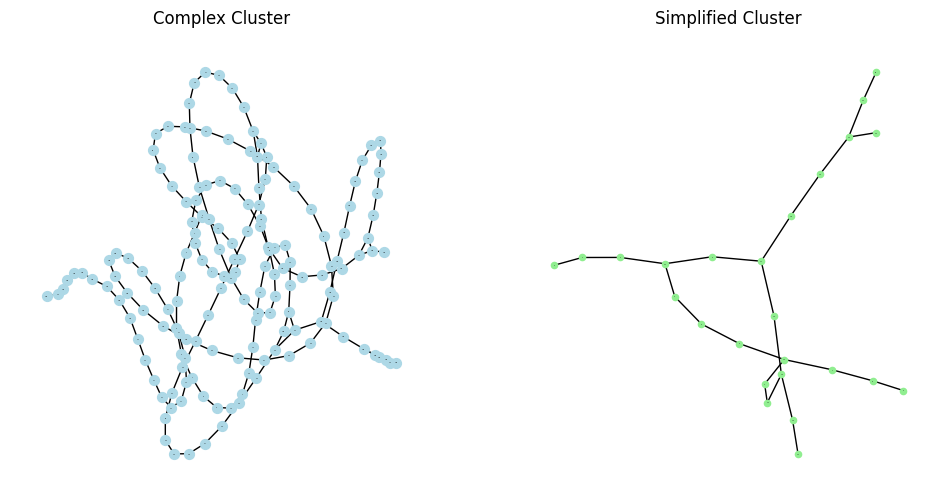

In [26]:
frame_index = 0
cluster_index = 17

if frame_index in all_adjacency_matrices and cluster_index in all_adjacency_matrices[frame_index]:
  complex_adj_matrix = all_adjacency_matrices[frame_index][cluster_index]
  simplified_adj_matrix = simplify_adjacency_matrix(complex_adj_matrix)
  simplified_adj_matrix_without_triangles = remove_triangles(simplified_adj_matrix)

  # Create graphs from the adjacency matrices
  G_complex = nx.from_numpy_array(np.array(complex_adj_matrix))

  G_simplified_without_triangles = nx.from_numpy_array(np.array(simplified_adj_matrix_without_triangles))

  pos1 = nx.spring_layout(G_complex)
  pos2 = nx.spring_layout(G_simplified_without_triangles)


  # Plot the graphs
  plt.figure(figsize=(12, 6))

  plt.subplot(121)
  nx.draw(G_complex,pos1, with_labels=True, node_color='lightblue', node_size=50, font_size=0)
  plt.title("Complex Cluster")

  plt.subplot(122)
  nx.draw(G_simplified_without_triangles,pos2, with_labels=True, node_color='lightgreen', node_size=20, font_size=0)
  plt.title("Simplified Cluster")

  plt.show()

else:
  print(f"No adjacency matrix found for frame {frame_index}, cluster {cluster_index}")


In [27]:
cycles = list(nx.cycle_basis(G_simplified_without_triangles))
num_cycles = len(cycles)
print(f"The graph G_simplified_with_triangles has {num_cycles} closed circuits.")


The graph G_simplified_with_triangles has 1 closed circuits.


In [28]:
# def count_white_pixels_in_cluster(frame, cluster):
#   """Counts the number of white pixels within a cluster in a frame."""
#   white_pixel_count = 0
#   for (x, y) in cluster:
#     if frame[x, y] > 0:
#       white_pixel_count += 1
#   return white_pixel_count


# # Create lists to store the results
# cluster_white_pixel_counts = []
# clusters_per_frame_counts = []

# # Process each frame in the TIFF file
# for frame_index, frame in enumerate(image_data):
#   clusters, _, _ = process_frame(frame)
#   num_clusters = len(clusters)
#   clusters_per_frame_counts.append(num_clusters)

#   frame_white_pixel_counts = []
#   for cluster_index, cluster in enumerate(clusters):
#       white_pixel_count = count_white_pixels_in_cluster(frame, cluster)
#       frame_white_pixel_counts.append(white_pixel_count)

#   cluster_white_pixel_counts.append(frame_white_pixel_counts)

# # Print the results
# for frame_index, frame_counts in enumerate(cluster_white_pixel_counts):
#   print(f"Frame {frame_index + 1}:")
#   for cluster_index, white_pixel_count in enumerate(frame_counts):
#     print(f"  Cluster {cluster_index + 1}: {white_pixel_count} white pixels")

# print("\nNumber of clusters per frame:")
# for frame_index, num_clusters in enumerate(clusters_per_frame_counts):
#   print(f"  Frame {frame_index + 1}: {num_clusters} clusters")


In [29]:
def calculate_degree_distribution(graph):
  """Calculates the degree distribution of a graph."""
  degree_counts = {}
  for node in graph.nodes():
    degree = graph.degree(node)
    if degree not in degree_counts:
      degree_counts[degree] = 0
    degree_counts[degree] += 1
  return degree_counts

# Initialize a dictionary to store degree distributions for each frame and cluster
frame_cluster_degree_distributions = {}

for frame_index in all_adjacency_matrices:
  frame_cluster_degree_distributions[frame_index] = {}
  for cluster_index in all_adjacency_matrices[frame_index]:
    complex_adj_matrix = all_adjacency_matrices[frame_index][cluster_index]
    simplified_adj_matrix = simplify_adjacency_matrix(complex_adj_matrix)
    simplified_adj_matrix_without_triangles = remove_triangles(simplified_adj_matrix)
    G_simplified_without_triangles = nx.from_numpy_array(np.array(simplified_adj_matrix_without_triangles))
    degree_counts = calculate_degree_distribution(G_simplified_without_triangles)
    frame_cluster_degree_distributions[frame_index][cluster_index] = degree_counts

# Example: Print the degree distribution for frame 7, cluster 44
frame_index = 7
cluster_index = 44

if frame_index in frame_cluster_degree_distributions and cluster_index in frame_cluster_degree_distributions[frame_index]:
  print(f"Frame: {frame_index}, Cluster: {cluster_index}, Degree Distribution:")
  print(frame_cluster_degree_distributions[frame_index][cluster_index])
else:
  print(f"No degree distribution found for frame {frame_index}, cluster {cluster_index}")


Frame: 7, Cluster: 44, Degree Distribution:
{1: 5, 2: 12, 3: 4, 5: 1}


In [30]:
# # Initialize lists to store the data
# frame_numbers = []
# modularity_values = []
# powerlaw_exponents = []

# # Process each frame in the TIFF file
# for frame_number, frame in enumerate(image_data):
#     _, adjacency_matrices, _ = process_frame(frame)

#     # Calculate modularity and powerlaw exponent for each cluster
#     for adjacency_matrix in adjacency_matrices:
#         modularity = calculate_modularity(adjacency_matrix)
#         exponent = calculate_powerlaw_exponent(adjacency_matrix)

#         # Store the data
#         frame_numbers.append(frame_number + 1)  # Add 1 to make frame numbers start from 1
#         modularity_values.append(modularity)
#         powerlaw_exponents.append(exponent)

# # Create a pandas DataFrame
# data = {'Frame': frame_numbers, 'Modularity': modularity_values, 'Powerlaw Exponent': powerlaw_exponents}
# df = pd.DataFrame(data)

# # Save the DataFrame to an Excel file
# df.to_excel('cluster_analysis.xlsx', index=False)

In [31]:

# # Find the centers of the clusters
# cluster_centers = find_cluster_centers(clusters)

# # Create a new frame with a white background
# white_bg_frame = np.ones_like(frame) * 255  # White background
# white_bg_frame[frame == 255] = 0  # Invert only white pixels to black, keep others white

# # Convert the grayscale image to RGB for better display with matplotlib
# white_bg_frame_rgb = cv2.cvtColor(white_bg_frame, cv2.COLOR_GRAY2RGB)

# # Plot the original image and the cluster visualization with centers
# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ax.imshow(white_bg_frame_rgb)
# ax.set_title("Original Frame with Cluster Centers")

# # Plot the centers
# for center_x, center_y in cluster_centers:
#     ax.plot(center_y, center_x, 'ro', markersize=1)  # Plot the center as a red dot

# plt.show()


In [32]:

#

# def calculate_average_distance(cluster_centers):
#   """
#   Calculates the average distance between all pairs of cluster centers.

#   Args:
#     cluster_centers: A list of (x, y) coordinates representing the center of each cluster.

#   Returns:
#     The average distance between all pairs of cluster centers.
#   """
#   total_distance = 0
#   num_pairs = 0

#   for i in range(len(cluster_centers)):
#     for j in range(i + 1, len(cluster_centers)):
#       x1, y1 = cluster_centers[i]
#       x2, y2 = cluster_centers[j]
#       distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
#       total_distance += distance
#       num_pairs += 1

#   if num_pairs == 0:
#     return 0  # Avoid division by zero if there are no pairs
#   else:
#     return total_distance / num_pairs

# # Calculate the average distance
# average_distance = calculate_average_distance(cluster_centers)
# print(f"Average distance between cluster centers: {average_distance}")


In [33]:
# # Calculate the modularity for each adjacency matrix in the list

# # You can then process the modularity values for each cluster, for example:
# for i, value in enumerate(modularity_values):
#     print(f"Modularity of cluster {i}: {value}")

# # Or calculate the average modularity:
# average_modularity = np.mean(modularity_values)
# print(f"Average modularity of the clusters: {average_modularity}")

In [34]:
# # Calculate the power law exponent for each adjacency matrix

# # Print the exponents
# for i, exponent in enumerate(powerlaw_exponents):
#     print(exponent)

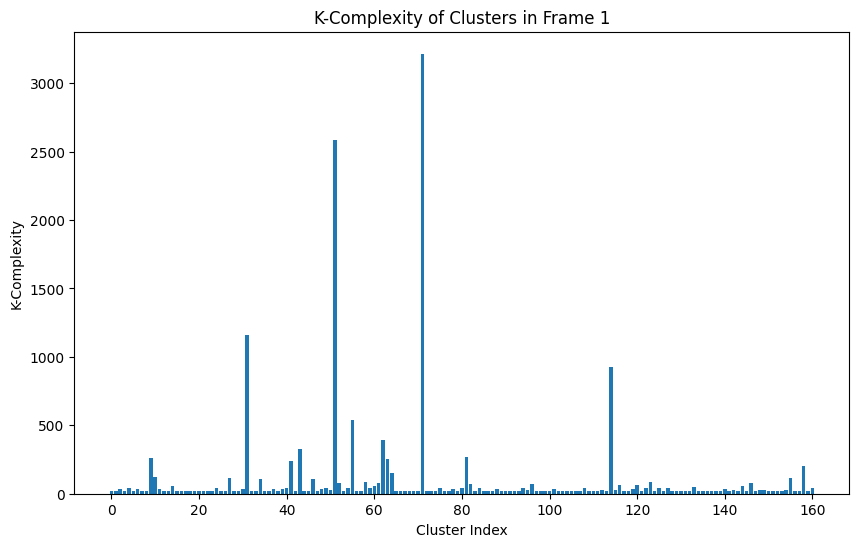

In [35]:
def calculate_k_complexity(adj_matrix):
    """
    Calculates K-complexity by compressing the binary adjacency matrix.
    The length of the compressed data is used as a proxy for K-complexity.
    """
    # Flatten the adjacency matrix to a binary string
    binary_str = ''.join(map(str, adj_matrix.flatten()))

    # Compress the binary string using zlib
    compressed_data = zlib.compress(binary_str.encode('utf-8'))

    # K-complexity approximation: length of the compressed data
    return len(compressed_data)


# Initialize a dictionary to store K-complexities for each frame and cluster
frame_cluster_k_complexities = defaultdict(dict)

for frame_index in all_adjacency_matrices:
  if frame_index == 1:  # Only process frame 1
    complexities = {}  # Initialize complexities for this frame
    for cluster_index in all_adjacency_matrices[frame_index]:
      complex_adj_matrix = all_adjacency_matrices[frame_index][cluster_index]
      simplified_adj_matrix = simplify_adjacency_matrix(complex_adj_matrix)
      k_complexity = calculate_k_complexity(simplified_adj_matrix)

      # Store the complexity for this cluster
      complexities[cluster_index] = k_complexity

    # Store the complexities for this frame
    frame_cluster_k_complexities[frame_index] = complexities

# Plot the K-complexities for frame 1
plt.figure(figsize=(10, 6))
plt.bar(frame_cluster_k_complexities[1].keys(), frame_cluster_k_complexities[1].values())
plt.xlabel("Cluster Index")
plt.ylabel("K-Complexity")
plt.title("K-Complexity of Clusters in Frame 1")
plt.show()


In [36]:
frame_EC = defaultdict(dict)

for frame_index in all_adjacency_matrices:
    for cluster_index in all_adjacency_matrices[frame_index]:
        complex_adj_matrix = all_adjacency_matrices[frame_index][cluster_index]
        graph = nx.from_numpy_array(np.array(complex_adj_matrix))
        simplified_adj_matrix = simplify_adjacency_matrix(complex_adj_matrix)
        simplified_adj_matrix_without_triangles = remove_triangles(simplified_adj_matrix)
        G_simplified_without_triangles = nx.from_numpy_array(np.array(simplified_adj_matrix_without_triangles))
        EC =  nx.number_of_nodes(graph) - nx.number_of_edges(graph) + len(nx.cycle_basis(G_simplified_without_triangles))

        frame_EC[frame_index][cluster_index] = EC


# def xlsx_with_EC(
#     frame_cluster_cyclomatic_complexities,
#     cluster_white_pixel_counts,
#     frame_cluster_degree_distributions,
#     output_filename=path,
# ):
#     """Creates an Excel file with Euler Characteristic data."""
#     wb = openpyxl.Workbook()
#     ws = wb.active
#     ws.title = "Euler Characteristic data"

#     headers = ["Frame", "Cluster", "PixelCount", "EC"]
#     ws.append(headers)

#     for frame_index, frame_data in enumerate(cluster_white_pixel_counts):
#         for cluster_index, white_pixel_count in enumerate(frame_data):
#             if (
#                 frame_index in frame_cluster_cyclomatic_complexities
#                 and cluster_index in frame_cluster_cyclomatic_complexities[frame_index]
#             ):
#                 cyclomatic_complexity = frame_cluster_cyclomatic_complexities[frame_index][
#                     cluster_index
#                 ]
#                 row = [frame_index + 1, cluster_index + 1, white_pixel_count, cyclomatic_complexity]

#                 if frame_index in frame_cluster_degree_distributions and cluster_index in frame_cluster_degree_distributions[frame_index]:
#                     degree_distribution = frame_cluster_degree_distributions[frame_index][cluster_index]
#                     for degree, count in degree_distribution.items():
#                         degree_column = f"Degree{degree}"
#                         if degree_column not in ws[1]:
#                             ws.cell(row=1, column=len(row) + 1).value = degree_column
#                         row.append(count)


#                 ws.append(row)

#     wb.save(output_filename)
#     print(f"Excel data with cyclomatic complexity saved to {output_filename}")


# # Create the Excel file with cyclomatic complexity
# xlsx_with_EC(
#     frame_EC,
#     cluster_white_pixel_counts,
#     frame_cluster_degree_distributions,
# )


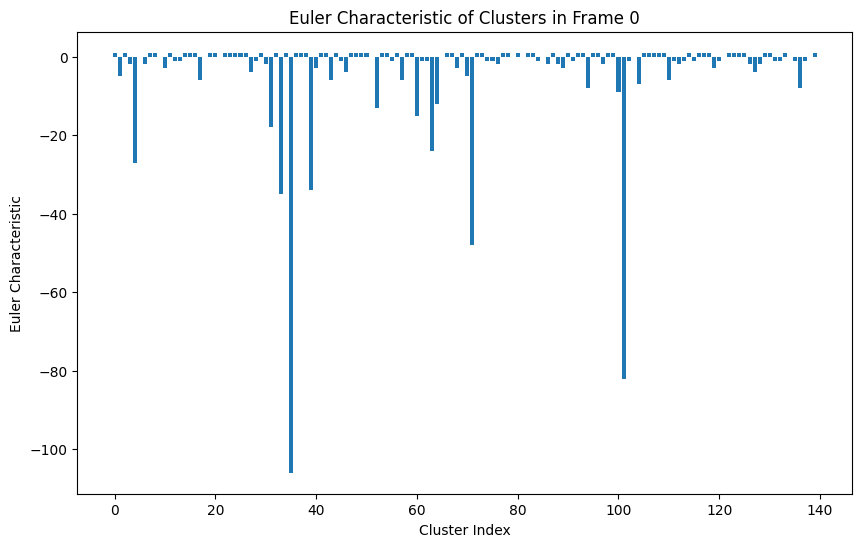

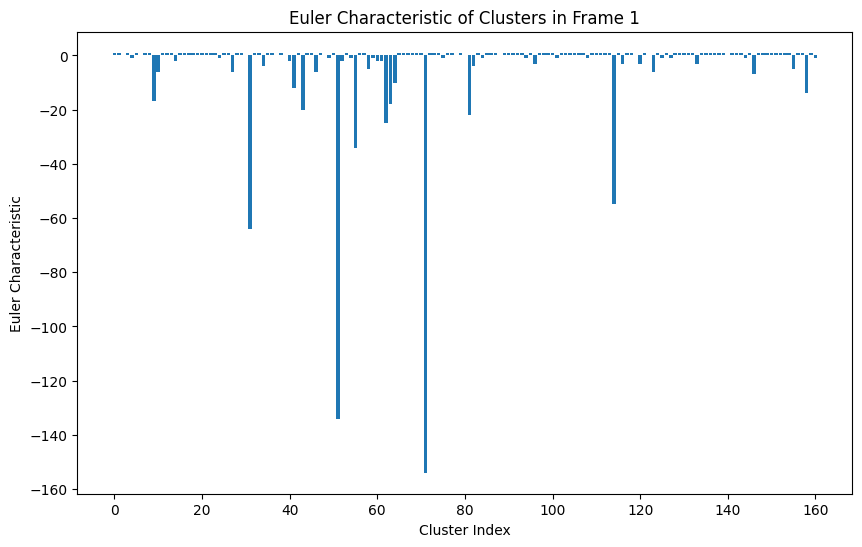

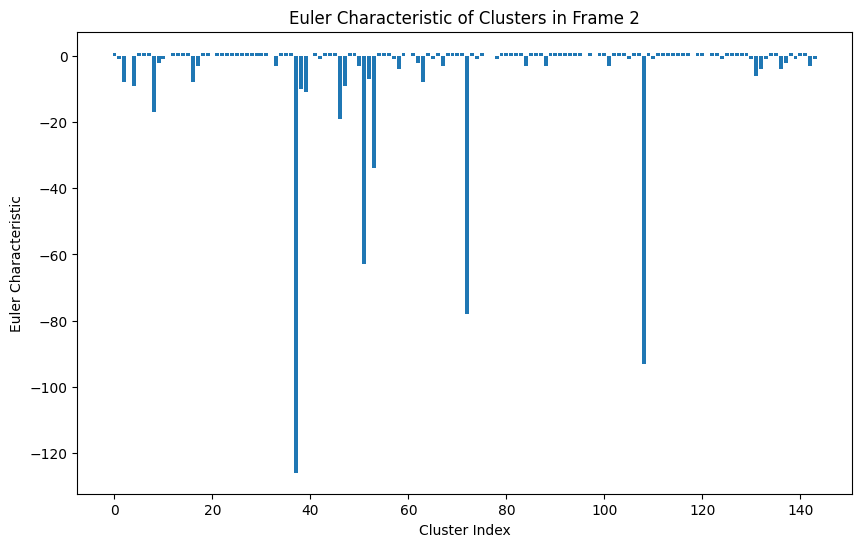

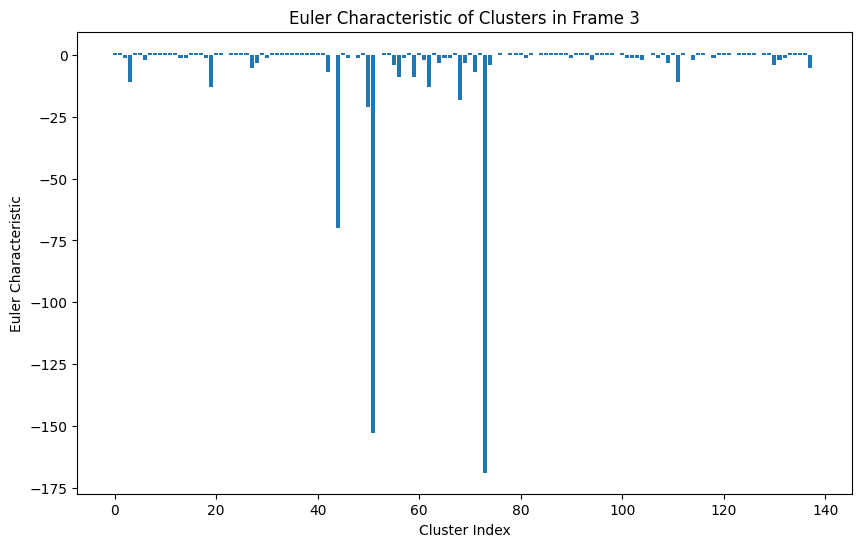

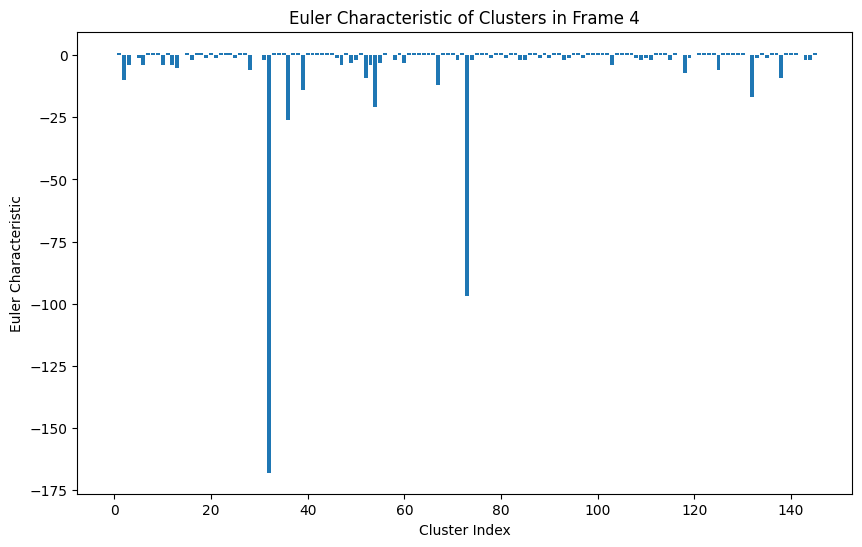

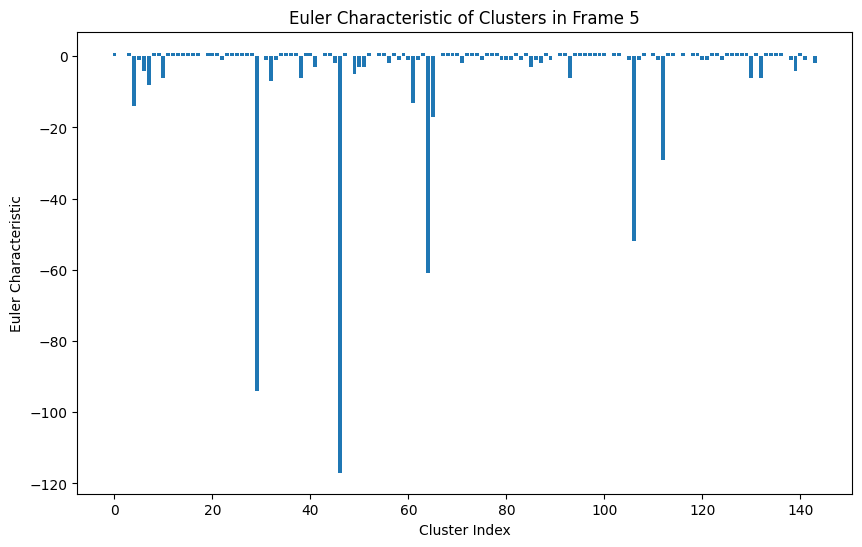

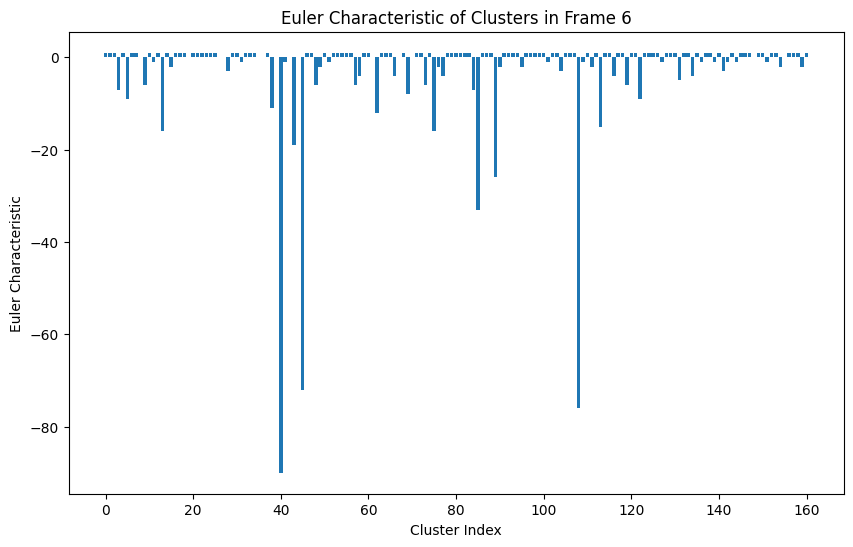

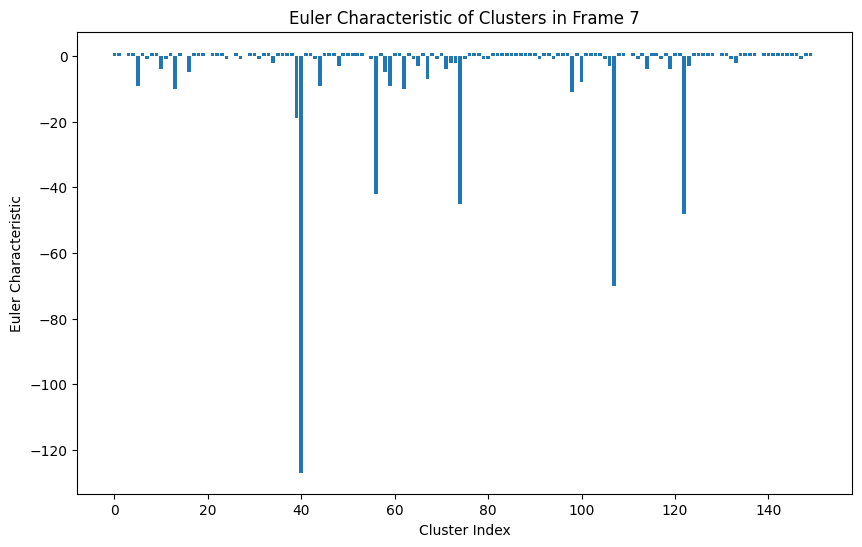

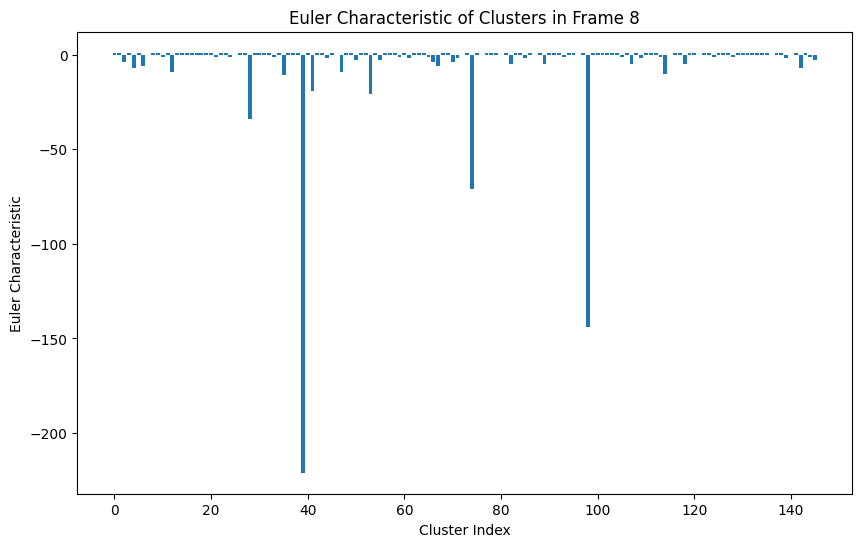

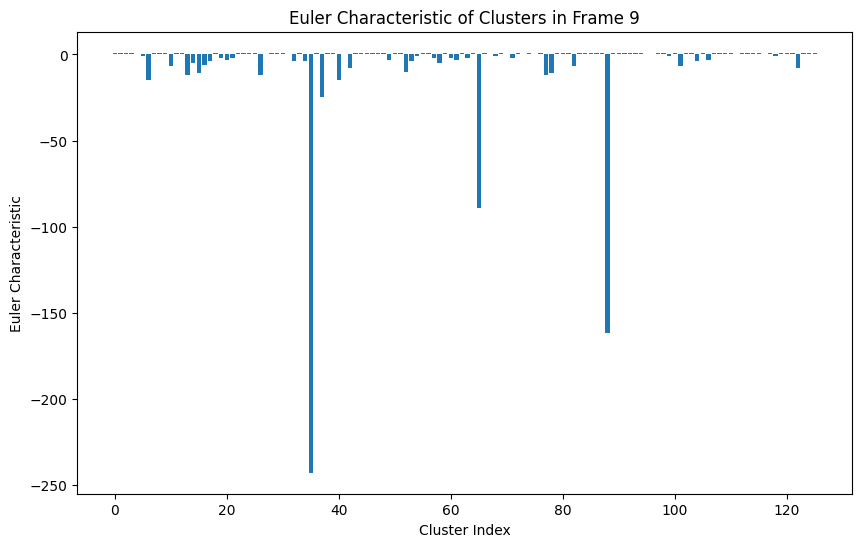

In [37]:
for frame_index in frame_EC:
    frame_complexities = frame_EC[frame_index]

    #Create the bar graph for the current frame
    plt.figure(figsize=(10, 6))
    plt.bar(frame_complexities.keys(), frame_complexities.values())
    plt.xlabel("Cluster Index")
    plt.ylabel("Euler Characteristic")
    plt.title(f"Euler Characteristic of Clusters in Frame {frame_index}")
    plt.show()


In [38]:
# prompt: In a similar way to the "display largest cluster" function, display the cluster wit the smallest EC value for each frame

def display_smallest_ec_cluster(frame_EC):
  """Displays the cluster with the smallest EC value for each frame."""
  for frame_index, frame_data in frame_EC.items():
    min_ec = float('inf')
    min_ec_cluster = None
    for cluster_index, ec_value in frame_data.items():
      if ec_value < min_ec:
        min_ec = ec_value
        min_ec_cluster = cluster_index
    print(f"Frame {frame_index}: Smallest EC value ({min_ec}) found in cluster {min_ec_cluster}")

display_smallest_ec_cluster(frame_EC)

Frame 0: Smallest EC value (-106) found in cluster 35
Frame 1: Smallest EC value (-154) found in cluster 71
Frame 2: Smallest EC value (-126) found in cluster 37
Frame 3: Smallest EC value (-169) found in cluster 73
Frame 4: Smallest EC value (-168) found in cluster 32
Frame 5: Smallest EC value (-117) found in cluster 46
Frame 6: Smallest EC value (-90) found in cluster 40
Frame 7: Smallest EC value (-127) found in cluster 40
Frame 8: Smallest EC value (-221) found in cluster 39
Frame 9: Smallest EC value (-243) found in cluster 35


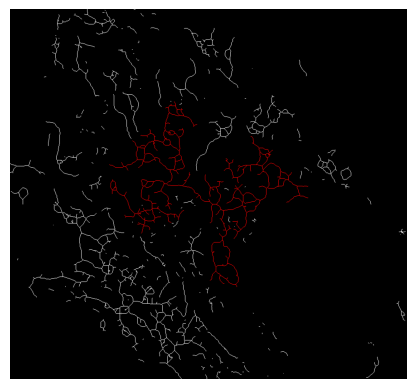

In [39]:
def display_cluster_coordinates_on_zoomed(frame, cluster, cluster_index, zoom_factor=2):
    """zooms in on a specific cluster and displays it with the cluster marked in red."""

    def find_min_max_coordinates(cluster):
        """finds the minimum and maximum x and y coordinates in a cluster."""
        min_x = min(coord[0] for coord in cluster)
        max_x = max(coord[0] for coord in cluster)
        min_y = min(coord[1] for coord in cluster)
        max_y = max(coord[1] for coord in cluster)
        return min_x, max_x, min_y, max_y

    min_x, max_x, min_y, max_y = find_min_max_coordinates(cluster)

    center_x = (min_x + max_x) // 2
    center_y = (min_y + max_y) // 2
    half_width = (max_y - min_y) // 2 * zoom_factor
    half_height = (max_x - min_x) // 2 * zoom_factor

    top = max(0, center_x - half_height)
    bottom = min(frame.shape[0], center_x + half_height)
    left = max(0, center_y - half_width)
    right = min(frame.shape[1], center_y + half_width)

    zoomed_region = frame[top:bottom, left:right].copy()

    zoomed_region = cv2.cvtColor(zoomed_region, cv2.COLOR_GRAY2RGB)
    adjusted_cluster_coordinates = [
        (x - top, y - left) for x, y in cluster
        if top <= x < bottom and left <= y < right
    ]

    for x, y in adjusted_cluster_coordinates:
        if 0 <= x < zoomed_region.shape[0] and 0 <= y < zoomed_region.shape[1]:  #Boundary check
            zoomed_region[x, y] = (255, 0, 0)

    cv2.imwrite(f'zoomed_cluster_{cluster_index}.jpg', zoomed_region)
    plt.imshow(zoomed_region)
    plt.axis('off')
    plt.show()

# Example usage
frame_index = 9
frame = image_data[frame_index]
cluster_index = 35  # Replace with desired cluster index
clusters, _, _ = process_frame(frame)
if clusters and 0 <= cluster_index < len(clusters):
    display_cluster_coordinates_on_zoomed(frame, clusters[cluster_index], cluster_index)

In [44]:
# Create a new dictionary to store the sorted data
sorted_frame_EC = {}

# Iterate through the frames and clusters
for frame_index in frame_EC:
  sorted_frame_EC[frame_index] = {}
  for cluster_index in frame_EC[frame_index]:
    # Sort the EC values for each frame from smallest to largest
    sorted_frame_EC[frame_index][cluster_index] = sorted(frame_EC[frame_index].values())


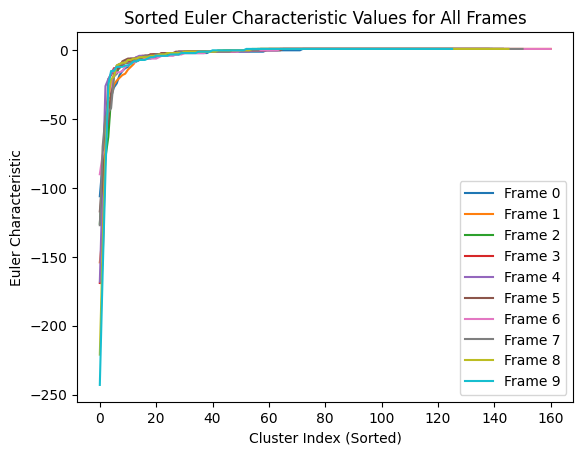

In [41]:
# prompt: Now for all the frames plot the sorted points on the same set of axis

import matplotlib.pyplot as plt

# Assuming you have a dictionary 'frame_EC' containing Euler characteristic values for each frame and cluster

# Create a figure and axes for the plot
fig, ax = plt.subplots()

# Iterate through the frames and clusters
for frame_index in frame_EC:
    frame_complexities = frame_EC[frame_index]

    # Sort the cluster indices based on Euler characteristic values
    sorted_indices = sorted(frame_complexities, key=lambda x: frame_complexities[x])

    # Plot the sorted Euler characteristic values for the current frame on the same axes
    x_values = list(range(len(sorted_indices)))  # X-axis values (cluster indices)
    y_values = [frame_complexities[i] for i in sorted_indices]  # Y-axis values (EC values)
    ax.plot(x_values, y_values, label=f"Frame {frame_index}")

# Add labels and title to the plot
ax.set_xlabel("Cluster Index (Sorted)")
ax.set_ylabel("Euler Characteristic")
ax.set_title("Sorted Euler Characteristic Values for All Frames")
ax.legend()

# Display the plot
plt.show()

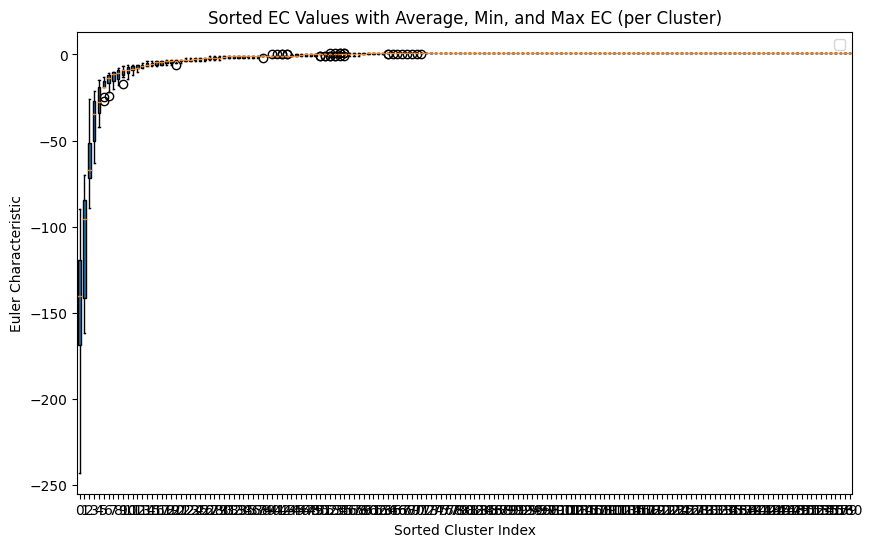

In [42]:
clusters_ec = {}

for frame_index in frame_EC:
    frame_complexities = frame_EC[frame_index]

    sorted_indices = sorted(frame_complexities, key=lambda x: frame_complexities[x])

    for sorted_pos, cluster_index in enumerate(sorted_indices):
        ec_value = frame_complexities[cluster_index]

        if sorted_pos not in clusters_ec:
            clusters_ec[sorted_pos] = []
        clusters_ec[sorted_pos].append(ec_value)  # Append sorted EC values for each cluster

cluster_indices = sorted(clusters_ec.keys())
boxplot_data = [clusters_ec[cluster] for cluster in cluster_indices]

average_ec = [np.mean(clusters_ec[cluster]) for cluster in cluster_indices]
min_ec = [np.min(clusters_ec[cluster]) for cluster in cluster_indices]
max_ec = [np.max(clusters_ec[cluster]) for cluster in cluster_indices]

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(boxplot_data, positions=cluster_indices, patch_artist=True)

###uncomment for extra data on the plot
# ax.plot(cluster_indices, average_ec, 'r-', marker='o', label='Average EC')
# ax.plot(cluster_indices, min_ec, 'g--', marker='x', label='Smallest EC', alpha=0.7)
# ax.plot(cluster_indices, max_ec, 'b--', marker='x', label='Largest EC', alpha=0.7)

ax.set_xlabel("Sorted Cluster Index")
ax.set_ylabel("Euler Characteristic")
ax.set_title("Sorted EC Values with Average, Min, and Max EC (per Cluster)")
ax.legend()

plt.show()



In [43]:
sorted_frame_data = {}

for frame_index in sorted(frame_EC.keys()):  # Iterate over sorted frame indices
    frame_complexities = frame_EC[frame_index]

    sorted_indices = sorted(frame_complexities, key=lambda x: frame_complexities[x])

    #collect EC values for each sorted cluster
    for sorted_pos, cluster_index in enumerate(sorted_indices):
        ec_value = frame_complexities[cluster_index]

        if sorted_pos not in sorted_frame_data:
            sorted_frame_data[sorted_pos] = []

        sorted_frame_data[sorted_pos].append(ec_value)

wb = openpyxl.Workbook()
ws = wb.active
ws.title = "EC Across Frames"

headers = [f"Frame{frame_index+1}: EC" for frame_index in frame_EC.keys()]
ws.append(headers)
for cluster_index, ec_values in sorted_frame_data.items():
    #add EC values for each cluster (in the corresponding column for each frame)
    ws.append(ec_values)

output_filename = path
wb.save(output_filename)
print(f"Euler Characteristic data saved to {output_filename}")


Euler Characteristic data saved to /content/C2-6Ra_1.2-2.xlsx
